<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Discovering Hidden Structures with Unsupervised Learning](08.00-Discovering-Hidden-Structures-with-Unsupervised-Learning.ipynb) | [Contents](../README.md) | [Compressing Color Spaces Using k-Means](08.02-Compressing-Color-Images-Using-k-Means.ipynb) >

# Understanding k-means clustering

The most essential clustering algorithm that OpenCV provides is $k$-means clustering, which
searches for a predetermined number of $k$ clusters (or groups) within an unlabeled
multidimensional dataset.

It does so by using two simple assumptions about what an optimal clustering should look
like:
- The center of each cluster is simply the arithmetic mean of all the points belonging to the cluster
- Each point in the cluster is closer to its own center than to other cluster centers

It's the easiest to understand the algorithm by looking at a concrete example.

## Implementing our first k-means example

First, let's generate a 2D dataset containing four distinct blobs. To emphasize that this is an
unsupervised approach, we will leave the labels out of the visualization. We will continue
using Matplotlib for all our visualization purposes:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Following the same recipe from earlier chapters, we will create a total of 300 blobs
(`n_samples=300`) belonging to four distinct clusters (`centers=4`):

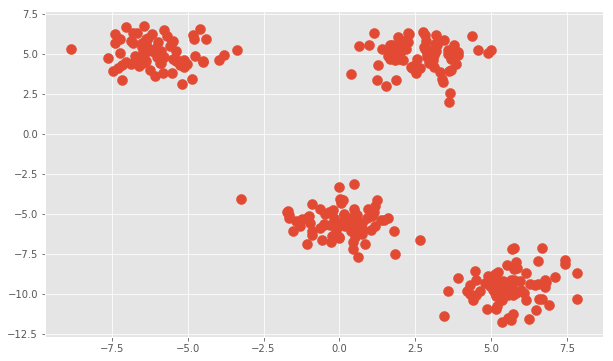

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=1.0, random_state=10)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=100);

Even without assigning target labels to the data, it is straightforward to pick out the four
clusters by eye. The $k$-means algorithm can do this, too, without having any information
about target labels or underlying data distributions.

Although $k$-means is, of course, a statistical model, in OpenCV, it does not come via the `ml`
module and the common train and predict API calls. Instead, it is directly available as
`cv2.kmeans`. In order to use the model, we have to specify some arguments, such as the
termination criteria and some initialization flags. Here, we will tell the algorithm to
terminate whenever the error is smaller than 1.0 (`cv2.TERM_CRITERIA_EPS`) or when ten
iterations have been executed (`cv2.TERM_CRITERIA_MAX_ITER`):

In [3]:
import cv2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

Then we can pass the preceding data matrix (`X`) to `cv2.means`. We also specify the number
of clusters (4) and the number of attempts the algorithm should make with different
random initial guesses (10), as shown in the following snippet:

In [4]:
import numpy as np
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 4,
                                          None, criteria, 10, flags)

Three different variables are returned. The first one, `compactness`, returns the sum of
squared distances from each point to their corresponding cluster centers. A high
**compactness score** indicates that all points are close to their cluster centers, whereas a low
compactness score indicates that the different clusters might not be well separated:

In [5]:
compactness

527.01581170992

Of course, this number strongly depends on the actual values in `X`. If the distances between
points were large to begin with, we cannot expect an arbitrarily small compactness score.
Hence, it is more informative to plot the data points, colored to their assigned cluster labels:

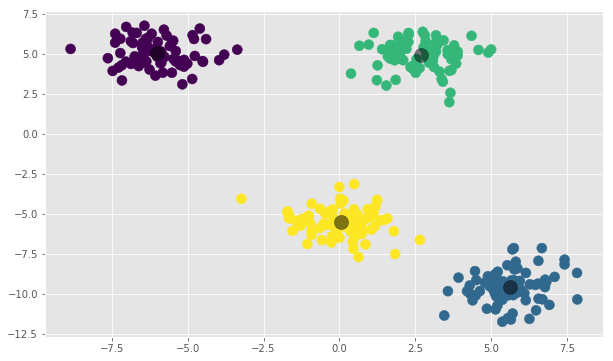

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news here is that the $k$-means algorithm (at least in this simple case) assigns the
points to clusters very similarly to how we might have, had we done the job by eye. But
how did the algorithm find these different clusters so quickly? After all, the number of
possible combinations of cluster assignments is exponential to the number of data points!
By hand, trying all possible combinations would have certainly taken forever.

Fortunately, an exhaustive search is not necessary. Instead, the typical approach that $k$-means
takes is to use an iterative algorithm, also known as **expectation-maximization**.

## Understanding expectation-maximization

$k$-means clustering is but one concrete application of a more general algorithm known as
expectation-maximization. In short, the algorithm works as follows:
1. Start with some random cluster centers.
2. Repeat until convergence:
   - Expectation step: Assign all data points to their nearest cluster center.
   - Maximization step: Update the cluster centers by taking the mean of all the points in the cluster.
   
Here, the expectation step is so named because it involves updating our expectation of
which cluster each point in the dataset belongs to. The maximization step is so named
because it involves maximizing a fitness function that defines the location of the cluster
centers. In the case of $k$-means, maximization is performed by taking the arithmetic mean of
all the data points in a cluster.

Refer to the book for step-by-step illustrations on how expectation-maximization works.

## Implementing our own expectation-maximization solution

The expectation-maximization algorithm is simple enough for us to code it up ourselves. To
do so, we will define a function `find_clusters(X, n_clusters, rseed=5)` that takes
as input a data matrix (`X`), the number of clusters we want to discover (`n_clusters`), and a
random seed (optional, `rseed`). As will become clear in a second, scikit-learn's
`pairwise_distances_argmin` function will come in handy:

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=5):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

We can apply our function to the preceding data matrix `X` we created. Since we know what
the data looks like, we know that we are looking for four clusters:

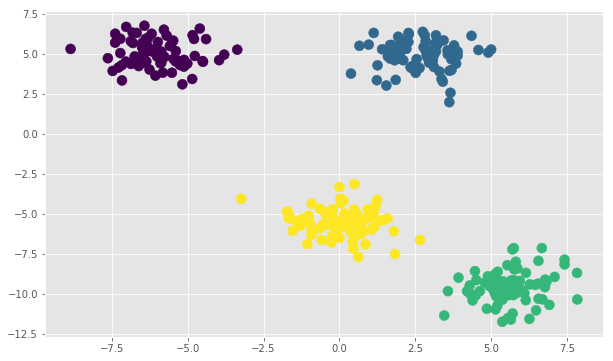

In [8]:
centers, labels = find_clusters(X, 4)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100);

As we can see, our home-made algorithm got the job done! Granted, this particular
clustering example was fairly easy, and most real-life implementations of $k$-means
clustering will do a bit more under the hood. But for now, we are happy.

## Knowing the limitations of expectationmaximization

For its simplicity, expectation-maximization performs incredibly well in a range of
scenarios. That being said, there are a number of potential limitations that we need to be
aware of:
- Expectation-maximization does not guarantee that we will find the globally best solution.
- We must know the number of desired clusters beforehand.
- The decision boundaries of the algorithms are linear.
- The algorithm is slow for large datasets.

Let's quickly discuss these potential caveats in a little more detail.

### First caveat: No guarantee of finding the global optimum

Although mathematicians have proved that the expectation-maximization step improves
the result in each step, there is still no guarantee that, in the end, we will find the global best
solution. For example, if we use a different random seed in our simple example (such as
using, seed 10 instead of 5), we suddenly get very poor results:

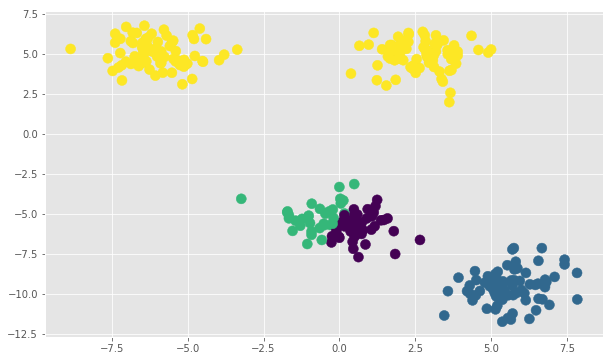

In [9]:
centers, labels = find_clusters(X, 4, rseed=10)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100);

What happened?

The short answer is that the random initialization of cluster centers was unfortunate. It led
to the center of the yellow cluster migrating in—between the two top blobs, essentially
combining them into one. As a result, the other clusters got confused because they suddenly
had to split two visually distinct blobs into three clusters.

For this reason, it is common for the algorithm to be run for multiple initial states. Indeed,
OpenCV does this by default (set by the optional `attempts` parameter).

### Second caveat: We must select the number of clusters beforehand

Another potential limitation is that $k$-means cannot learn the number of clusters from the
data. Instead, we must tell it how many clusters we expect beforehand. You can see how
this could be problematic for complicated real-world data that you don't fully understand
yet.

From the viewpoint of $k$-means, there is no wrong or nonsensical number of clusters. For
example, if we ask the algorithm to identify six clusters in the dataset generated in the
preceding section, it will happily proceed and find the best six clusters:

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 6, None, criteria, 10, flags)

Here, we used the exact same preceding code and only changed the number of clusters
from four to six. We can plot the data points again and color them according to the target
labels:

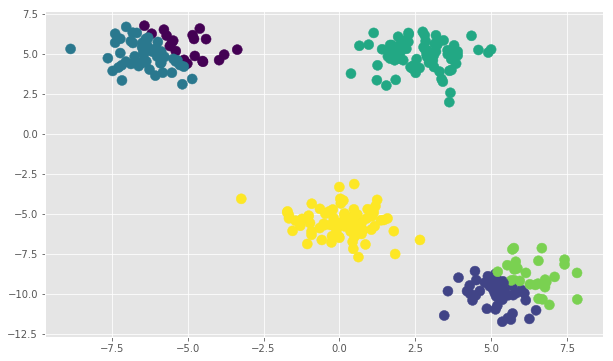

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100);

Since we generated the data ourselves, we know that each data point comes from a total of
four distinct clusters. For more complicated data, where we are uncertain about the right
number of clusters, there are a few things we could try.

First and foremost, there is the **elbow method**, which asks us to repeat the clustering for a
whole range of $k$ values and record the compactness value:

In [12]:
kvals = np.arange(2, 10)
compactness = []
for k in kvals:
    c, _, _ = cv2.kmeans(X.astype(np.float32), k, None, criteria, 10, flags)
    compactness.append(c)

This will result in a plot that looks like an *arm*. The point that lies at the *elbow* is the number
of clusters to pick:

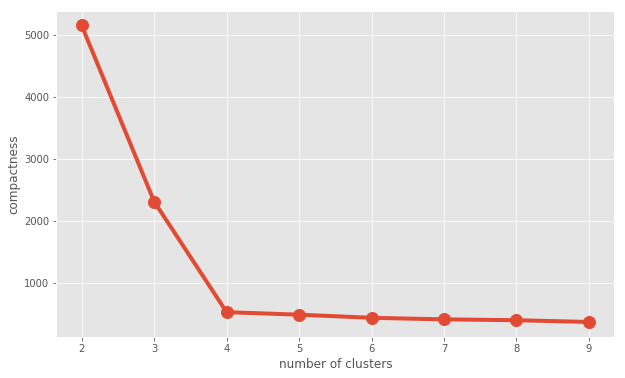

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(kvals, compactness, 'o-', linewidth=4, markersize=12);
plt.xlabel('number of clusters')
plt.ylabel('compactness')

In our case, we would pick the number four. The reasoning behind this is that moving from
left to right, four is the smallest number of clusters that gives a very compact representation.
Three clusters give us a representation that is only half as compact as four clusters.
Choosing five clusters or more does not further improve the compactness. Thus, four
should be our best guess as to the number of clusters.

A list of more sophisticated methods is given in the book.

### Third caveat: Cluster boundaries are linear

The $k$-means algorithm is based on a simple assumption, which is that points will be closer
to their own cluster center than to others. Consequently, $k$-means always assumes linear
boundaries between clusters, meaning that it will fail whenever the geometry of the clusters
is more complicated than that.

We see this limitation for ourselves by generating a slightly more complicated dataset.
Instead of generating data points from Gaussian blobs, we want to organize the data into
two overlapping half circles. We can do this using scikit-learn's `make_moons`. Here, we
choose 200 data points belonging to two half circles, in combination with some Gaussian
noise:

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=12)

This time, we tell $k$-means to look for two clusters:

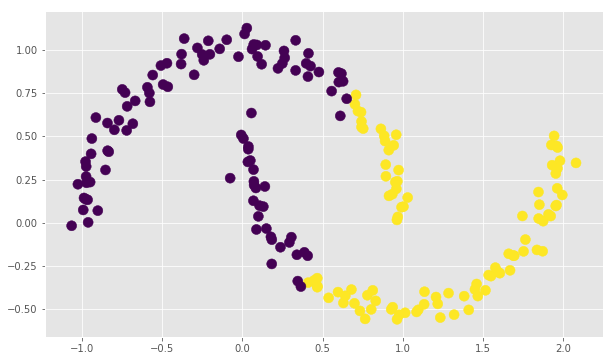

In [15]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 2, None, criteria, 10, flags)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100);

As is evident from the plot, $k$-means failed to identify the two half circles and instead split
the data with what looks like a diagonal straight line (from bottom left to top right).

This scenario should ring a bell. We had the exact same problem when we talked about
linear SVMs in [Chapter 6](06.00-Detecting-Pedestrians-with-Support-Vector-Machines.ipynb), *Detecting Pedestrians with Support Vector Machines*. The idea there
was to use the kernel trick in order to transform the data into a higher-dimensional feature
space. Can we do the same here?

We most certainly can. There is a form of kernelized k-means that works akin to the kernel
trick for SVMs, called **spectral clustering**. Unfortunately, OpenCV does not provide an
implementation of spectral clustering. Fortunately, scikit-learn does:

In [16]:
from sklearn.cluster import SpectralClustering

The algorithm uses the same API as all other statistical models: We set optional arguments
in the constructor and then call `fit_predict` on the data. Here, we want to use the graph
of the nearest neighbors to compute a higher-dimensional representation of the data and
then assign labels using $k$-means:

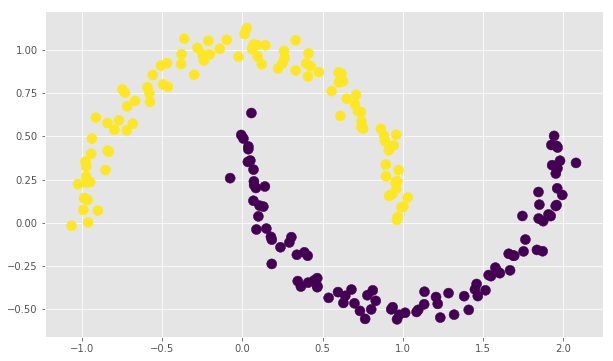

In [17]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100);

We see that spectral clustering gets the job done. Alternatively, we could have transformed
the data into a more suitable representation ourselves and then applied OpenCV's linear $k$-means
to it. The lesson of all this is that perhaps, again, feature engineering saves the day.

### Fourth caveat: k-means is slow for a large number of samples

The final limitation of $k$-means is that it is relatively slow for large datasets. You can
imagine that quite a lot of algorithms might suffer from this problem. However, $k$-means is
affected especially badly: each iteration of $k$-means must access every single data point in
the dataset and compare it to all the cluster centers.

You might wonder whether the requirement to access all data points during each iteration
is really necessary. For example, you might just use a subset of the data to update the
cluster centers at each step. Indeed, this is the exact idea that underlies a variation of the
algorithm called batch-based k-means. Unfortunately, this algorithm is not implemented in
OpenCV.

Despite the limitations discussed earlier, $k$-means has a number of interesting applications,
especially in computer vision.

<!--NAVIGATION-->
< [Discovering Hidden Structures with Unsupervised Learning](08.00-Discovering-Hidden-Structures-with-Unsupervised-Learning.ipynb) | [Contents](../README.md) | [Compressing Color Spaces Using k-Means](08.02-Compressing-Color-Images-Using-k-Means.ipynb) >